# Problem Definition:
> Airline ticket prices are highly dynamic and can vary significantly based on a multitude of factors, including but not limited to the destination, departure date, time of booking, airline carrier, class of service, season, and other external factors such as holidays and global events. Travelers often face the challenge of finding the best deal for their travel plans, and predicting the price trend for a specific route can be a valuable asset.

> "Easemytrip" serves as an online platform for individuals to book their flight tickets, making it a go-to choice for prospective passengers looking to purchase airfare. A comprehensive examination of the data will unlock valuable insights that can greatly benefit travelers. This data will not only be leveraged to gain deeper insights into the various factors that impact flight ticket prices.

> The problem is to develop a machine learning model that can accurately predict the prices of airline flights. This prediction will assist travelers and travel agencies in making informed decisions and planning their travel itineraries based on anticipated airfare.

# Gather Initial Data:
> Selenium and Octoparse scraping tool was used to extract data from the `makemytrip` website. Data was collected in two parts: one for economy class tickets and another for business class tickets. A total of 300153 flight booking options was extracted from the site. Data was collected for 50 days, from November 15th 2023 to January 5th 2024.

The `Web_Scraping.ipynb` file contain details about the Selenium web scraping method.

# Dataset:
The dataset at hand comprises details regarding flight bookings made through the Easemytrip website for travel between India's six major metropolitan cities. In this clean dataset, you will find a total of 300,153 data entries, each accompanied by 11 distinct features. These features are essential for understanding and analyzing the dynamics of flight bookings and pricing within this specific travel context.

The various features of the cleaned dataset are explained below:

- `Airline`: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
- `Flight`: Flight stores information regarding the plane's flight code. It is a categorical feature.
`Source City`: City from which the flight takes off. It is a categorical feature having 6 unique cities.
- `Departure Time`: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
- `Stops`: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
- `Arrival Time`: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
- `Destination City`: City where the flight will land. It is a categorical feature having 6 unique cities.
- `Class`: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
- `Duration`: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
- `Price`: Target variable stores information of the ticket price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-dark")
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('flight_dataset.csv')

In [3]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))

There are 300153 observations for 11 predictors.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


8 features are categorical and 3 are numeric

In [6]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

There is no missing values as we have gathered the data from `makemytrip` using `selenium` & `octoparse`.

In [7]:
df[df.duplicated()]

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price


No dupliacate values, each flight is unique for that particular day.

In [8]:
df.describe() # Only for numeric features

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


Flight price ranges from 1105-123071. 

In [9]:
df.describe(include='O') # Only for object/categorical features

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
count,300153,300153,300153,300153,300153,300153,300153,300153
unique,6,1561,6,6,3,6,6,2
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy
freq,127859,3235,61343,71146,250863,91538,59097,206666


##### For object type features: 
- Most of the flights starts at morning and reach at night
- We have mostly economy class people 
- Top airline is vistara with the flight number UK-706

# Exploratory Data Analysis

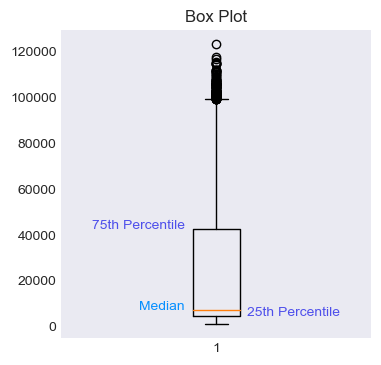

In [10]:
price = df.price
plt.figure(figsize=(4, 4))
plt.boxplot(price)
plt.title("Box Plot")
plt.text(x=0.75, y=price.median(), s="Median", c='#068FFF')
plt.text(x=1.1, y=price.quantile(0.25), s="25th Percentile", c='#4E4FEB')
plt.text(x=0.6, y=price.quantile(0.75), s="75th Percentile", c='#4E4FEB');

In [11]:
print("Mean:", round(price.mean(), 2), "Median:", price.median())

Mean: 20889.66 Median: 7425.0


- Clearly we can se that the mean is around 20,000 and median is 7400, this difference is due to Business and economy class.
- This distribution is skewed towards right (Positive Skewed Data) which means that majority of the people belongs to Economy class. 

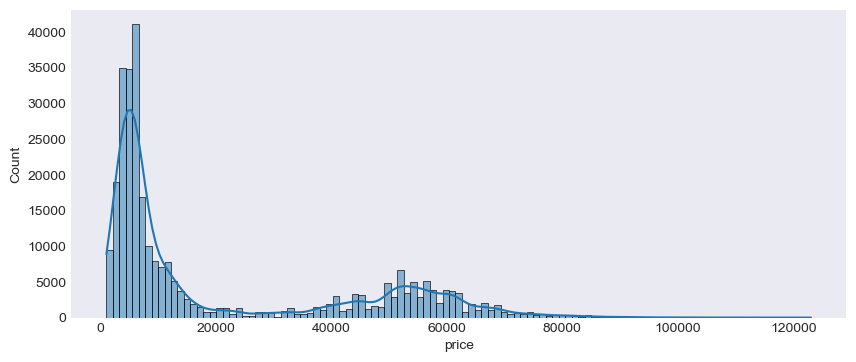

In [12]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='price', kde=True);

- There are 2 peaks in the graph, the dispersion seems to be composed by two gaussian curves one for economy class and another for business class. 
- It is rightly skewed data and seems to have outliers
- We can't consider them as ouliers because of the distribusion is based on class price

#### What is the difference in ticket prices between Economy and Business class?

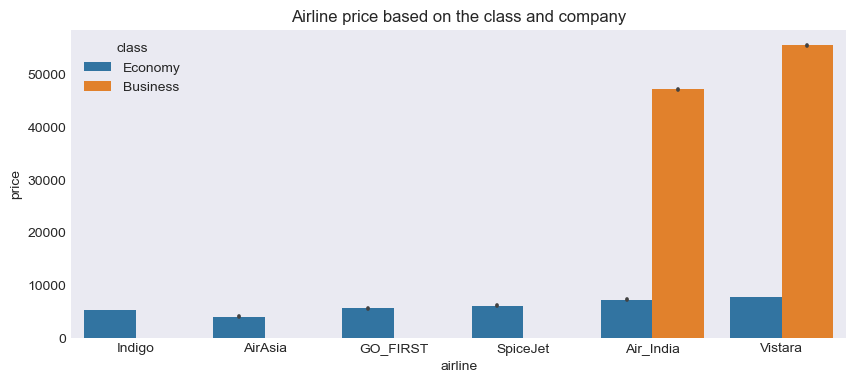

In [13]:
plt.figure(figsize=(10, 4))
sns.barplot(x='airline', y='price', hue="class", data=df.sort_values("price"))
plt.title("Airline price based on the class and company");

- There are only 2 airlines for Business class Air india and Vistara with highest price range
- There's big price difference between 2 classes

#### How does the ticket price vary across different airlines?

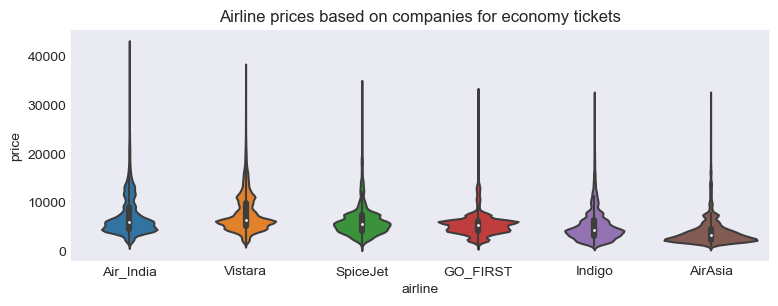

In [14]:
economy = df[df["class"]=='Economy']
plt.figure(figsize=(9, 3))
sns.violinplot(y = "price", x = "airline",data = economy.sort_values("price", ascending=False))
plt.title("Airline prices based on companies for economy tickets");

- Air Aisa flights have the cheapest price for economy class tickets 
- Air India and vistara are more expensive 

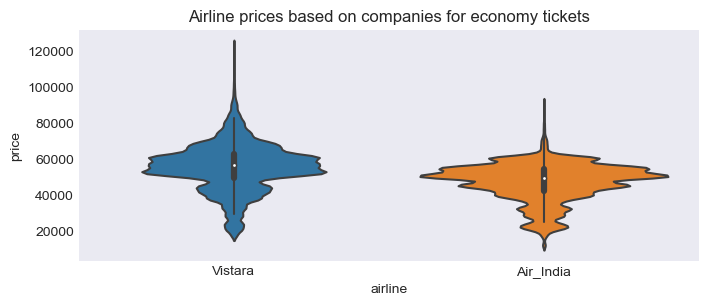

In [15]:
business = df[df["class"]=='Business']
plt.figure(figsize=(8, 3))
sns.violinplot(y = "price", x = "airline",data = business.sort_values("price", ascending=False))
plt.title("Airline prices based on companies for economy tickets");

Vistara is way more expensive than Air India 

#### What impact does purchasing tickets within 1 or 2 days before departure have on the ticket prices?

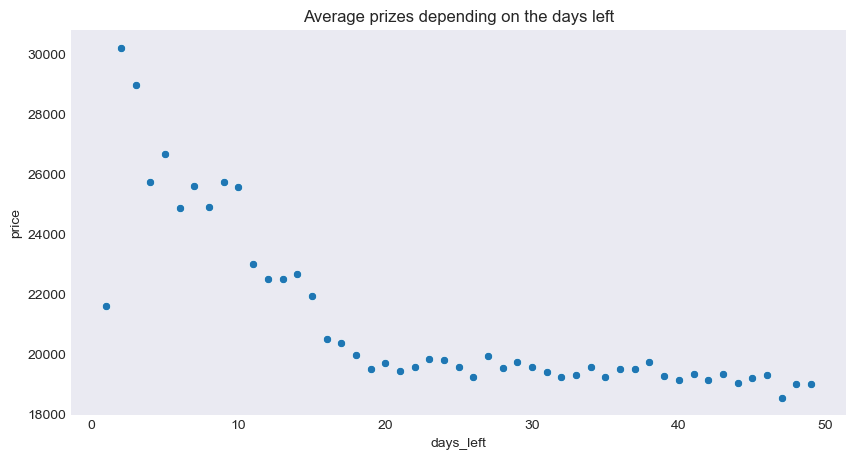

In [16]:
df_temp = df.groupby(['days_left'], as_index=False)['price'].mean()
plt.figure(figsize=(10,5))
sns.scatterplot(x="days_left", y="price", data=df_temp)
plt.title("Average prizes depending on the days left");

- From 2 to 20 days before it seems to have a little higher price range 
- From 20 to 50 days before the price is stable and constant
- This proves that price may fluctuate based on number of days left for the flight

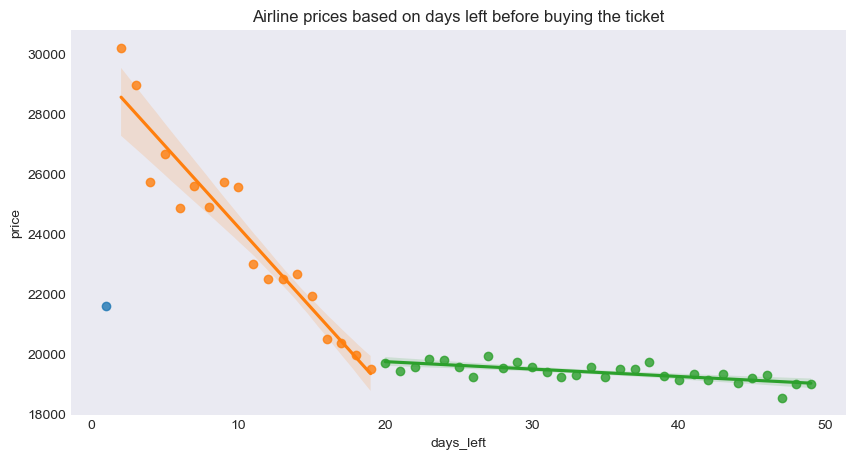

In [17]:
plt.figure(figsize=(10,5))
price_current_day = df_temp[df_temp["days_left"]==1]
price_before_2_20 = df_temp[(df_temp["days_left"]>=2)&(df_temp["days_left"]<20)]
price_before_20_50 = df_temp[df_temp["days_left"]>=20]
sns.regplot(x=price_current_day.days_left, y=price_current_day.price)
sns.regplot(x=price_before_2_20.days_left, y=price_before_2_20.price)
sns.regplot(x=price_before_20_50.days_left, y=price_before_20_50.price)
plt.title("Airline prices based on days left before buying the ticket");

The graph illustrates a gradual increase in prices leading up to the flight, followed by a sudden and significant surge in the last 20 days before departure. Interestingly, prices experience a noteworthy drop just one day before the flight, often reaching up to three times less than their peak. This pattern could be attributed to airlines strategically adjusting ticket prices to maximize seat occupancy. In an effort to fill remaining seats and ensure optimal capacity, airlines may choose to lower prices close to the departure date, creating a potential opportunity for cost-conscious travelers to secure more affordable fares.

#### Is there a relationship between the departure and arrival times and the variation in ticket prices?

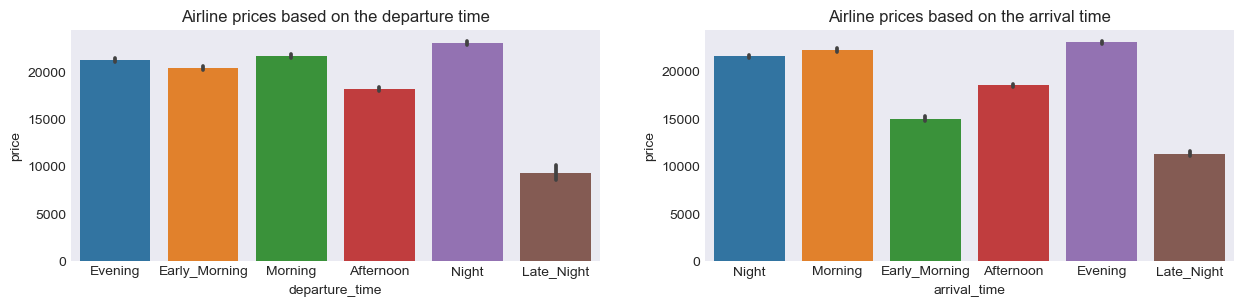

In [18]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
sns.barplot(data=df, x='departure_time', y='price')
plt.title("Airline prices based on the departure time")

plt.subplot(1, 2, 2)
sns.barplot(data=df, x='arrival_time', y='price')
plt.title("Airline prices based on the arrival time");

- Leaving at late night or arriving at late night remains the cheapest way to travel
- Arriving early in the morning is also cheap
- Afternoon flight are a bit cheaper than evening, morning and night flight

#### Is there any correlation between the number of stops and the corresponding flight prices?

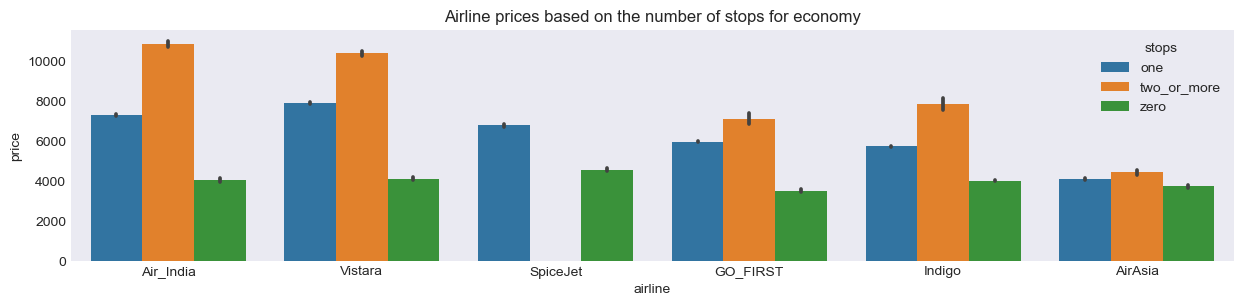

In [19]:
plt.figure(figsize=(15, 3))
sns.barplot(x ="airline", y="price", hue="stops",data=economy.sort_values("price", ascending = False))
plt.title("Airline prices based on the number of stops for economy");

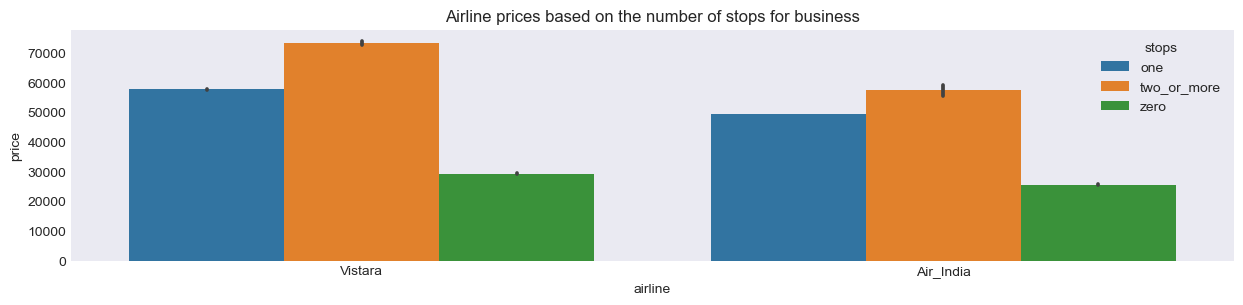

In [20]:
plt.figure(figsize=(15, 3))
sns.barplot(x ="airline", y="price", hue="stops",data=business.sort_values("price", ascending = False))
plt.title("Airline prices based on the number of stops for business");

The number of stops corresponds to higher flight prices, with the exception of AirAsia. Remarkably, AirAsia bucks this trend, demonstrating a relatively constant pricing structure regardless of the number of stops. This distinctive behavior and the unique analysis of AirAsia's pricing suggest characteristics typically associated with low-cost carriers.

# Flight Price Prediction

In [21]:
def prepare_dataset():
    df = pd.read_csv('flight_dataset.csv')
    df.stops = df.stops.map({'zero': 0, 'one': 1, 'two_or_more': 3})
    df['class'] = df['class'].map({'Economy': 0, 'Business': 1})
    df.drop(columns='flight', inplace=True)
    df.drop_duplicates(inplace=True, ignore_index=True)
    col_dummy = ['airline','source_city','departure_time','arrival_time','destination_city']
    df = pd.get_dummies(df, columns=col_dummy, dtype=int)
    return df

In [22]:
df = prepare_dataset()

In [23]:
df.head()

,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0,0,2.17,1,5953,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,2.33,1,5953,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,0,2.17,1,5956,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,2.25,1,5955,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,2.33,1,5955,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [24]:
features = ['stops','class','duration','days_left']

In [25]:
vif = pd.DataFrame()
vif['Columns'] = features
vif['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
vif

,Columns,VIF
0,stops,4.092219
1,class,1.444878
2,duration,4.118469
3,days_left,2.790636


There is no evidence of multicollinearity among the features, allowing us to proceed with the model-building process.

### Feature Scalling

In [26]:
scale = StandardScaler() # Z-Score 

In [27]:
df.iloc[:, 2:5] = scale.fit_transform(df.iloc[:, 2:5])

### Data splitting for model training 

In [28]:
X = df.drop(columns='price')
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(208558, 89382, 208558, 89382)

# Selecting best models
- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree 
- K Nearest Neighbors
- Adaptive Boosting
- Xtreme Gradient Boosting

In [29]:
models = dict()

models["LinearRegression"]={"model":LinearRegression()}
models["Ridge"]={"model":Ridge()}
models["Lasso"]={"model":Lasso()}
models["DecisionTree"]={"model":DecisionTreeRegressor()}
models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_jobs=5, n_neighbors=50)}
models["AdaptiveBoosting"]={"model":AdaBoostRegressor()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10)}

In [30]:
def cross_validation(model, X, y):
    score = cross_val_score(model, X, y, cv=5, scoring="r2")
    score = score.mean()
    return score

In [31]:
trained_models = dict()
def model_scores(models, X_train, y_train):
    for name,model in models.items():
        trained_model = model["model"].fit(X_train,y_train)
        score = cross_validation(trained_model, X_train, y_train)
        trained_models[name] = [trained_model, score]

In [33]:
model_scores(models, X_train, y_train)

In [34]:
for name, li in trained_models.items():
    print(10*"-", name, "-"*10)
    print("Score:", li[1])
    print("\n")

---------- LinearRegression ----------
Score: 0.9071442414910331


---------- Ridge ----------
Score: 0.9071443833413607


---------- Lasso ----------
Score: -2.222726474676584e-05


---------- DecisionTree ----------
Score: 0.9755853473280329


---------- KNeighborsRegressor ----------
Score: 0.8135491795416427


---------- AdaptiveBoosting ----------
Score: 0.9286631567737567


---------- XGBRegressor ----------
Score: 0.9829451066624412





> Negative score in lasso regression may suggest that the model struggles to capture meaningful patterns in your data, and it might be worth exploring alternative modeling approaches that better suit the characteristics of your dataset.

> Xtreme Gradient Boosting (XGBoost) has demonstrated impressive performance with an exceptionally high score of approximately 98%, showcasing its efficacy in capturing complex relationships within the data.

> While the Decision Tree model exhibits strong training performance, there are indications that it might be overfitting the data. Pruning the tree to enhance its generalization ability is advisable, though it's worth noting that this process might be computationally intensive, especially given the limited number of records (3 lack)

> KNeighborsRegressor is Computationally intensive because of it's nature to solve the problem using distance method.

In [35]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
DT_Tuned = GridSearchCV(trained_models['DecisionTree'][0] , param_grid, cv=5)
DT_Tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [36]:
DT_Tuned_Model = DT_Tuned.best_estimator_

In [37]:
DT_Tuned_Model.score(X_test, y_test)

0.9824246250277647

> After fine-tuning the Decision Tree model, there was a noticeable improvement in its performance. This enhancement suggests that the tuning process was effective in mitigating overfitting and refining the model's ability to generalize patterns in the data. The adjusted Decision Tree now demonstrates improved predictive capabilities, resulting in a more robust and accurate representation of the underlying relationships within the dataset.

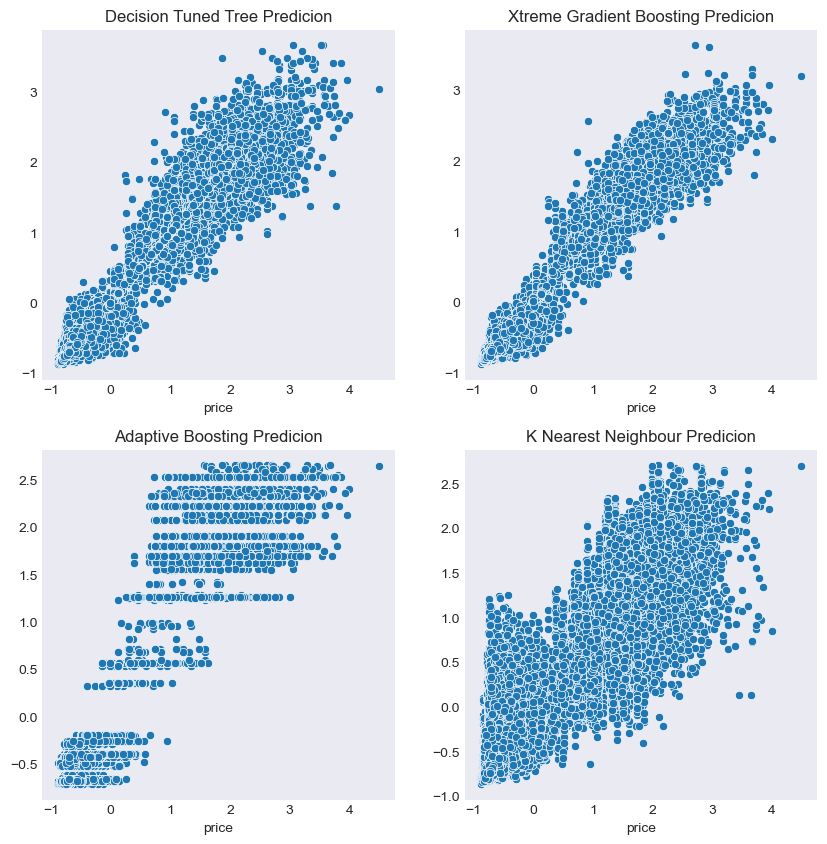

In [38]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
y_pred = DT_Tuned_Model.predict(X_test)
score_r2 =  r2_score(y_test, y_pred)
sns.scatterplot(x=y_test, y=y_pred)
plt.title("Decision Tuned Tree Predicion")

plt.subplot(2, 2, 2)
y_pred = trained_models['XGBRegressor'][0].predict(X_test)
score_r2 =  r2_score(y_test, y_pred)
sns.scatterplot(x=y_test, y=y_pred)
plt.title("Xtreme Gradient Boosting Predicion")

plt.subplot(2, 2, 3)
y_pred = trained_models['AdaptiveBoosting'][0].predict(X_test)
score_r2 =  r2_score(y_test, y_pred)
sns.scatterplot(x=y_test, y=y_pred)
plt.title("Adaptive Boosting Predicion")

plt.subplot(2, 2, 4)
y_pred = trained_models['KNeighborsRegressor'][0].predict(X_test)
score_r2 =  r2_score(y_test, y_pred)
sns.scatterplot(x=y_test, y=y_pred)
plt.title("K Nearest Neighbour Predicion");

# Conclusion

> 1. The model that gives the best result is the XGBRegressor and Tuned Decision Tree with on the test dataset an R^2 score equals to 98%.

> 2. There is a substantial price difference between business and economy class flight tickets. On average, business class tickets tend to be 6.5 times pricier than their economy counterparts.

> 3. Vistara and Air India emerge as the higher-priced carriers, while AirAsia stands out as the more budget-friendly option. Notably, when considering business class tickets, only Vistara and Air India are offered, with Vistara holding a slightly higher price point compared to Air India.

> 4. Typically, ticket prices exhibit a gradual increase until 20 days before the flight, at which point they undergo a significant surge. However, on the day just before the flight, there's often an opportunity to find tickets at a fraction of the cost, possibly up to three times cheaper, as some seats may remain unsold.

> 5. Analysis of flight timings reveals that departures during the early morning, afternoon, and late night periods generally offer more budget-friendly ticket options. Conversely, evening departures tend to be associated with higher prices.

> 6. When considering the departure cities: 
> - Flights originating from Delhi are often the most economical, while those from other cities exhibit comparable average prices, with a slight premium for Chennai. 
> - Regarding the destination cities, flights to Delhi are commonly the least expensive, while those bound for Bangalore tend to be the costliest.

In [40]:
import pickle
with open('XGB_model.pkl', 'wb') as model_file:
    pickle.dump(trained_models['XGBRegressor'][0], model_file)

In [41]:
with open('DT_Tuned_model.pkl', 'wb') as model_file:
    pickle.dump(DT_Tuned_Model, model_file)